In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead)
| YrFireName                  | Year and name of the fire.                                    
| Times_burned                | The number of times this tree was burned                                           
| Species                     |  Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number                                                   
| Genus_species               |  Genus and species of tree                                     
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters). NA = not assessed.
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters). NA = not assessed
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('data/FTM_trees.csv')


/var/folders/ck/21jw_cxj7j984t_wcgbyrv200000gn/T/ipykernel_33853/4268755570.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('data/FTM_trees.csv')


In [3]:
# Select desired columns for model analysis
trees_dat = trees_dat[['YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post', 'yr1status']]
trees_dat.columns

Index(['YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm',
       'HT_m', 'CR_pre', 'CR_post', 'yr1status'],
      dtype='object')

In [4]:
# Check for NAs in the df
trees_dat.isna().sum()
trees_dat = trees_dat.dropna()
print(f"Number of observations: {len(trees_dat)}")

Number of observations: 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [5]:
# Change the data type of the categorical predictors to zero-based integers
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}_num"] = trees_dat[col].astype('category').cat.codes

trees_dat.dtypes

YrFireName            object
Times_burned           int64
Species               object
Genus_species         object
DBH_cm               float64
HT_m                 float64
CR_pre               float64
CR_post              float64
yr1status            float64
YrFireName_num          int8
Species_num             int8
Genus_species_num       int8
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [6]:
# Assign predictors and outcomes
X = trees_dat.drop(['Species', 'Genus_species', 'YrFireName', 'yr1status'], axis=1)
y = trees_dat['yr1status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [7]:
# Calculate the number of observations in train and test
train_obs = len(X_train)
test_obs = len(X_test)

# Verify the training and testing set size
print("Training set observations:", train_obs)
print("Testing set observations:", test_obs)

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [8]:
# Fit logistic classifier
model = LogisticRegression().fit(X_train_scaled, y_train)

# Predictions using model
y_train_pred = model.predict(X_train_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
acc_train = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {acc_train:.4f}")

Training Accuracy: 0.9451


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Training Accuracy: 0.9399

Metrics from Confusion Matrix:
Sensitivity (true positive rate): 0.955
Specificity (true negative rate): 0.705

True Positives (correctly predicted presence): 9844
False Positives (Incorrectly predicted presence): 189
True Negatives (correctly predicted absence): 451
False Negatives (incorrectly predicted absence): 469


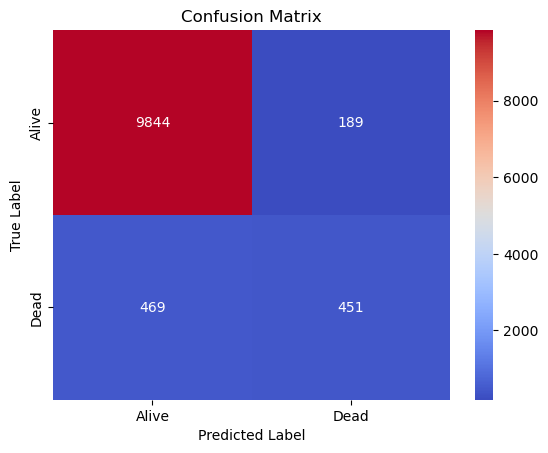

In [11]:
# Predictions using model
y_test_pred = model.predict(X_test_scaled)

# Calculate accuracy
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {acc_test:.4f}")

# Calculate metrics
cm = confusion_matrix(y_test, y_test_pred)
TN = cm[1,1]
TP = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

sensitivity = TP / (TP + FN) # guessed positives over total actual positives
specificity = TN / (TN + FP)

print("\nMetrics from Confusion Matrix:")
print(f"Sensitivity (true positive rate): {sensitivity:.3f}")
print(f"Specificity (true negative rate): {specificity:.3f}")
print(f"\nTrue Positives (correctly predicted presence): {TP}")
print(f"False Positives (Incorrectly predicted presence): {FP}")
print(f"True Negatives (correctly predicted absence): {TN}")
print(f"False Negatives (incorrectly predicted absence): {FN}")

#Plot confusion matrix 
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm',xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model performed well on the unseen data with an accuracy of approximately 94%. Yes, the model does perform differently on observations of trees that survived versus trees that died. Our sensitivity was 95% while our specificity was 70%. This indicates that the model performs better on alive trees (the positive) than the dead trees (the negative). Additionally, there is a class imbalance in the dataset because the total number of actual alive trees and actual dead trees is not equal. There are more alive trees than dead trees in the dataset as a whole. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

Because we have a class imbalance towards majority alive trees, a model that always predicted alive trees would still perform fairly well. I think it's accuracy would be good, but still less than the logistic model. 

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.9172

Dummy Confusion Matrix:


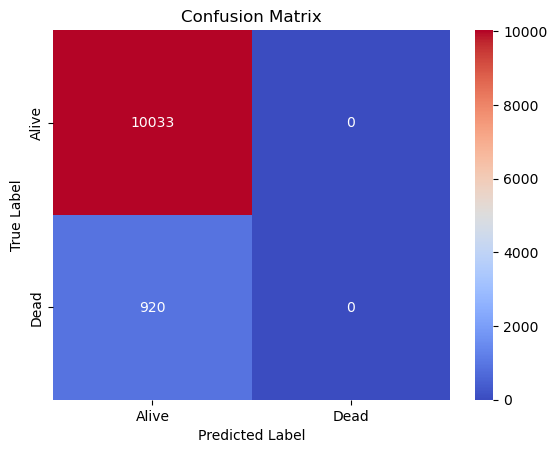

In [12]:
# Train majority classifier
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train_scaled, y_train)

dummy_train_pred = dummy_classifier.predict(X_train_scaled)

dummy_test_pred = dummy_classifier.predict(X_test_scaled)

# Calculate accuracy score
dummay_acc = accuracy_score(y_train, dummy_train_pred)


# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummay_acc:.4f}")
print("\nDummy Confusion Matrix:")
cm = confusion_matrix(y_test, dummy_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm',xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [35]:
# Logistic classifier AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Logistic AUC: {roc_auc:.4f}")

Logistic AUC: 0.9181


In [36]:
# Dummy classifier AUC
dummy_pred_prob = dummy_classifier.predict_proba(X_test_scaled)[:, 1]
dummy_roc_auc = roc_auc_score(y_test, dummy_pred_prob)

print(f"Dummy AUC: {dummy_roc_auc:4f}")

Dummy AUC: 0.500000


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

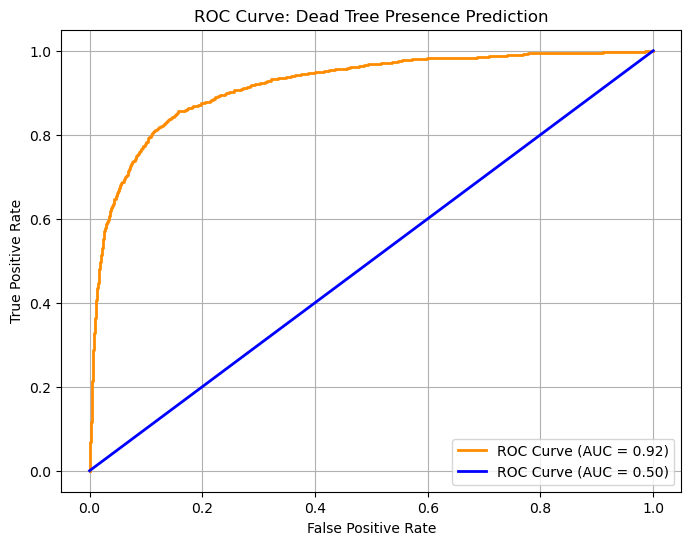

In [ ]:
# Generate ROC curve data for logistic and dummy classifiers
fpr_log, tpr_log, threshold_log = roc_curve(y_test, y_pred_prob)
fpr_dummy, tpr_dummy, threshold_dummy = roc_curve(y_test, dummy_pred_prob)

# Plot both curves
plt.figure(figsize=(8,6))

# Logistic curve
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# Dummy curve
plt.plot(fpr_dummy, tpr_dummy, color='blue', lw=2, label=f'ROC Curve (AUC = {dummy_roc_auc:.2f})')

plt.title('ROC Curve: Dead Tree Presence Prediction')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()



How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The logistic model compares significantly better than the dummy classifier. We can see that the AUC of the dummy is only 0.5 while the logistic AUC is 0.92. This tells us that it can be dangerous to only evaluate a moel based on the accuracy of the predictions. More information using ROC and AUC is required to have a full understanding of classifier accuracy.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [60]:
# Define coefficients and feature names
coeffs = model.coef_[0]
features = X.columns

# Compile lists into a data frame
importance_df = pd.DataFrame({
    'Features': features,
    'Coefficients': coeffs
}).set_index('Features')

# Print the sorted feature importance
print(importance_df)


                   Coefficients
Features                       
Times_burned           0.000000
DBH_cm                 0.421324
HT_m                  -1.165414
CR_pre                 0.123414
CR_post               -2.494974
YrFireName_num        -0.660497
Species_num            0.541509
Genus_species_num     -0.067867


-2.4949744225411536

Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy? 

The most important features in our model are height (m) and post-fire live crown ratio. These coefficients have the largest magnitude, indicating they have the most influence on tree surivial. I think the important implication here for forest management and conservation strategy is that taller trees are more likely to survive. As crown ratio is also based on the height of the tree and the amount of crown left post-fire is a strong indicator of survival, this tells us that if a tall tree's foliage is able to escape the worst of the burn by being higher up, it has a higher survivial rate. 

If I were a forest manager, I would try and prioritze the longevity of middle-aged trees such that they can reach their peak height faster because our models indicate that a taller tree is more likely to survive a fire. 